In [4]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from utils import load_data
from plotting import plot_image
import matplotlib.pyplot as plt


In [2]:
data = load_data()
for key, value in data.items():
    print(f"{key}: {value.shape}")

# use only the first channel (ET)
ZB_train, ZB_val, ZB_test = data["ZB_train"][:, :, :, 0], data["ZB_val"][:, :, :, 0], data["ZB_test"][:, :, :, 0]



ZB_train: (102000, 18, 14, 3)
ZB_val: (34000, 18, 14, 3)
ZB_test: (34000, 18, 14, 3)
tt_lep_train: (14958, 18, 14, 3)
tt_lep_val: (4987, 18, 14, 3)
tt_lep_test: (4987, 18, 14, 3)


(array([  5.,  12.,  43.,  97., 181., 290., 361., 600., 661., 727., 767.,
        818., 835., 850., 893., 783., 775., 715., 681., 634., 479., 531.,
        382., 352., 338., 291., 238., 236., 197., 159., 146., 110., 104.,
         86.,  79.,  70.,  58.,  62.,  42.,  47.,  27.,  26.,  27.,  20.,
         17.,  13.,   8.,   9.,   6.,   6.,  10.,   6.,   5.,   7.,   2.,
          3.,   4.,   4.,   2.,   4.,   2.,   4.,   1.,   2.,   0.,   1.,
          0.,   1.,   0.,   2.,   0.,   1.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([  62.  ,   88.14,  114.28,  140.42,  166.56,  192.7 ,  218.84,
         244.98,  271.12,  297.26,  323.4 ,  349.54,  375.68,  401.82,
         427.96,  454.1 ,  480.24,  506.38,  532.52,  558.66,  584.8 ,
         610.94,  637.08,  663.22,  689.36,  715.5 ,  741.64,  767.78,
         793.92,  820.06,  846.2 ,

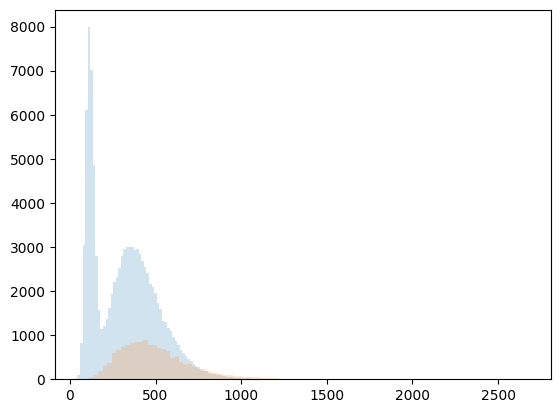

In [5]:
et_zb = np.sum(ZB_train, axis=(1, 2))
et_tt = np.sum(data["tt_lep_train"][:, :, :, 0], axis=(1, 2))
plt.hist(et_zb, bins=100, alpha=0.2)
plt.hist(et_tt, bins=100, alpha=0.2)


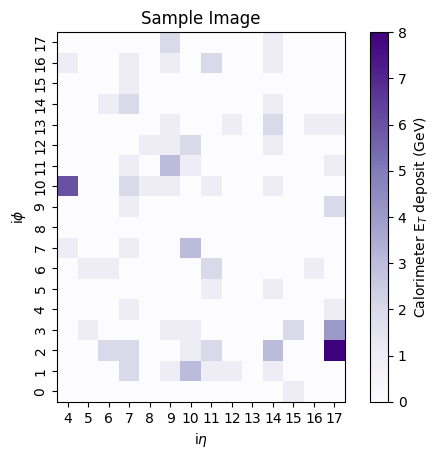

In [6]:
plot_image(ZB_train[42, :, :], "Sample Image")

In [7]:
# train a convolutional autoencoder only on inliers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, Activation, AveragePooling2D,
                                     UpSampling2D, Dense, Flatten, Reshape)


def get_teacher_model():
    inputs = Input(shape=(18, 14, 1), name="teacher_inputs_")
    x = Reshape((18, 14, 1), name="teacher_reshape")(inputs)
    x = Conv2D(8, (3, 3), strides=1, padding="same", name="teacher_conv2d_1")(x)
    x = Activation("relu", name="teacher_relu_1")(x)
    x = AveragePooling2D((2, 2), name="teacher_pool_1")(x)
    x = Conv2D(16, (3, 3), strides=1, padding="same", name="teacher_conv2d_2")(x)
    x = Activation("relu", name="teacher_relu_2")(x)
    x = Flatten(name="teacher_flatten")(x)
    x = Dense(32, activation="relu", name="teacher_latent")(x)
    x = Dense(9 * 7 * 16, name="teacher_dense")(x)
    x = Reshape((9, 7, 16), name="teacher_reshape2")(x)
    x = Activation("relu", name="teacher_relu_3")(x)
    x = Conv2D(16, (3, 3), strides=1, padding="same", name="teacher_conv2d_3")(x)
    x = Activation("relu", name="teacher_relu_4")(x)
    x = UpSampling2D((2, 2), name="teacher_upsampling")(x)
    x = Conv2D(8, (3, 3), strides=1, padding="same", name="teacher_conv2d_4")(x)
    x = Activation("relu", name="teacher_relu_5")(x)
    outputs = Conv2D(
        1,
        (3, 3),
        activation="relu",
        strides=1,
        padding="same",
        name="teacher_outputs",
    )(x)
    return Model(inputs, outputs, name="teacher")


In [8]:
# train on inliers only
teacher_model = get_teacher_model()

print(f"number of parameters: {teacher_model.count_params()}")
teacher_model.compile(optimizer='adam', loss='mse')
history = teacher_model.fit(
    ZB_train, ZB_train,
    epochs=10,
    batch_size=128,
    shuffle=True,
    validation_data=(ZB_val, ZB_val)
)

number of parameters: 70353
Epoch 1/10
797/797 [==============================] - 8s 9ms/step - loss: 3.8188 - val_loss: 3.4245
Epoch 2/10
797/797 [==============================] - 8s 10ms/step - loss: 3.3284 - val_loss: 3.2445
Epoch 3/10
797/797 [==============================] - 10s 12ms/step - loss: 3.1642 - val_loss: 3.0985
Epoch 4/10
797/797 [==============================] - 10s 13ms/step - loss: 3.0437 - val_loss: 3.0070
Epoch 5/10
797/797 [==============================] - 10s 12ms/step - loss: 2.9522 - val_loss: 2.9432
Epoch 6/10
797/797 [==============================] - 10s 13ms/step - loss: 2.9040 - val_loss: 2.9042
Epoch 7/10
797/797 [==============================] - 10s 12ms/step - loss: 2.8687 - val_loss: 2.8647
Epoch 8/10
797/797 [==============================] - 10s 12ms/step - loss: 2.8399 - val_loss: 2.8432
Epoch 9/10
797/797 [==============================] - 11s 13ms/step - loss: 2.8172 - val_loss: 2.8211
Epoch 10/10
797/797 [==============================] - 10

In [9]:
X_signal = data["tt_lep_val"][:, :, :, 0]

preds_bg = teacher_model.predict(ZB_val).squeeze(-1)
mse_bg = np.mean(np.square(ZB_val - preds_bg), axis=(1, 2))

preds_sig = teacher_model.predict(X_signal).squeeze(-1)
mse_sig = np.mean(np.square(X_signal - preds_sig), axis=(1, 2))


156/156 [==============================] - 0s 2ms/step


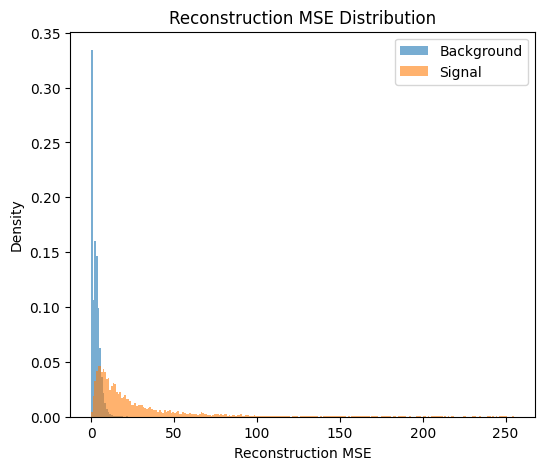

In [10]:
# plot MSE dists
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 5))
bins = range(256)
plt.hist(mse_bg, bins=bins, alpha=0.6, label='Background', density=True)
plt.hist(mse_sig, bins=bins, alpha=0.6, label='Signal', density=True)
plt.xlabel('Reconstruction MSE')
plt.ylabel('Density')
plt.title('Reconstruction MSE Distribution')
plt.legend()

In [11]:
# plot roc curve
from sklearn.metrics import roc_curve, auc
y_true = np.concatenate([np.zeros_like(mse_bg), np.ones_like(mse_sig)])
y_scores = np.concatenate([mse_bg, mse_sig])
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

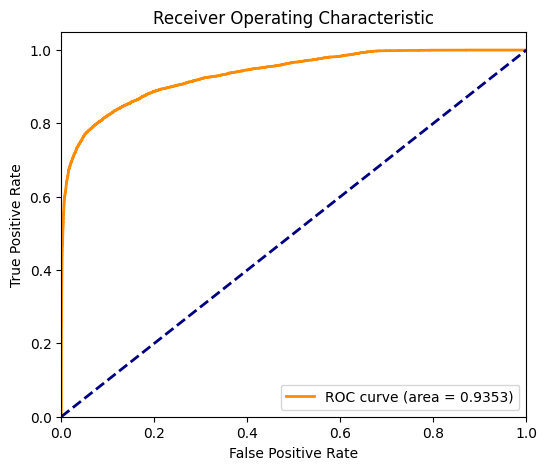

In [12]:
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.4f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend()

In [13]:
# make predictions and save to file

X_tt_lep_test = data["tt_lep_test"][:, :, :, 0]

X_test = np.concatenate([ZB_test, X_tt_lep_test], axis=0)

preds_test = teacher_model.predict(X_test).squeeze(-1)
mse_test = np.mean(np.square(X_test - preds_test), axis=(1, 2))

# save as submission.csv file for kaggle
import pandas as pd

submission = pd.DataFrame({
    "Id": np.arange(len(mse_test)),
    "Predicted": mse_test
})

submission.to_csv("data/submission.csv", index=False)


1219/1219 [==============================] - 2s 2ms/step
